# **Ultra-Resolving Face Images by Discriminative Generative Networks (UR-DGN) (2016)**


```
@inproceedings{yu2016ultra,
  title={Ultra-resolving face images by discriminative generative networks},
  author={Yu, Xin and Porikli, Fatih},
  booktitle={European conference on computer vision},
  pages={318--333},
  year={2016},
  organization={Springer}
}
```



### **Step 1: Mount Google Drive & Load Dataset**




In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
from PIL import Image
import numpy as np
import tensorflow as tf

# Enable GPU if available
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Image dimensions
HR_SIZE = 128
LR_SIZE = 16
CHANNELS = 3

# Normalize to [-1, 1]
def normalize(img):
    return (img / 127.5) - 1.0

def denormalize(img):
    return (img + 1.0) * 127.5

# Function to downsample HR image to LR
def downsample(image, lr_size=LR_SIZE):
    return tf.image.resize(image, [lr_size, lr_size], method='area')

# Function to preprocess HR and create LR
def preprocess_image(image):
    hr = tf.image.resize(image, [HR_SIZE, HR_SIZE])
    lr = downsample(hr)
    return normalize(lr), normalize(hr)

Num GPUs Available: 0


In [4]:
# Path to your HR dataset
HR_DATASET_DIR = '/content/drive/MyDrive/Research/Images'

# Get image paths
image_paths = glob.glob(os.path.join(HR_DATASET_DIR, '*.jpg'))[:10000]  # limit for now

def load_image(path):
    img = Image.open(path).convert('RGB').resize((128, 128))
    img = np.array(img).astype(np.float32)
    return normalize(img)

type(image_paths)


list

In [5]:
len(image_paths)

100

## **Step 2: Create Dataset Loader**

In [6]:
BATCH_SIZE = 32

def preprocess_pair(img):
    #hr = img
    hr = tf.image.resize(img, [HR_SIZE, HR_SIZE])
    lr = tf.image.resize(hr, [16, 16], method='area')
    return lr, hr

def load_dataset(image_paths):
    imgs = [load_image(p) for p in image_paths]
    dataset = tf.data.Dataset.from_tensor_slices(imgs)
    dataset = dataset.map(lambda img: preprocess_pair(img), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

dataset = load_dataset(image_paths)


## **Step 3: Define Generator (G) – Deconvolutional Network**

In [13]:
def build_generator():
    model = models.Sequential()

    model.add(layers.Input(shape=(16, 16, 3)))
    model.add(layers.Conv2DTranspose(16, kernel_size=3, strides=1, padding='same',activation='relu'))


    # 16x16 → 32x32
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu'))

    # 32x32 → 64x64
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', activation='relu'))

    # 64x64 → 128x128
    model.add(layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', activation='relu'))

    # Final output: 128x128x3
    model.add(layers.Conv2DTranspose(3, kernel_size=5, padding='same', activation='tanh'))

    return model

# Initialize and check
generator = build_generator()
generator.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_30             │ (None, 16, 16, 16)     │           448 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (None, 32, 32, 64)     │         9,280 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_32             │ (None, 64, 64, 128)    │       204,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_33             │ (None, 128, 128, 256)  │       819,456 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_34             │ (None, 128, 128, 3)    │        19,203 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,315 (4.02 MB)

 Trainable params: 1,053,315 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def build_generator_old():
    model = models.Sequential()

    model.add(layers.Input(shape=(16, 16, 3)))  # Input LR
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.UpSampling2D())  # 32x32
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.UpSampling2D())  # 64x64
    model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(layers.UpSampling2D())  # 128x128
    model.add(layers.Conv2D(3, 3, padding='same', activation='tanh'))  # Output HR

    return model

generator = build_generator()
generator.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_25             │ (None, 16, 16, 16)     │           448 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 32, 32, 64)     │         9,280 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_27             │ (None, 64, 64, 128)    │       204,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_28             │ (None, 128, 128, 256)  │       819,456 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_29             │ (None, 128, 128, 3)    │        19,203 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,315 (4.02 MB)

 Trainable params: 1,053,315 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

## **Step 4: Define Discriminator (D) – CNN Classifier**

In [16]:
def build_discriminator():
    model = models.Sequential()

    model.add(layers.Input(shape=(128, 128, 3)))
    model.add(layers.Conv2D(16, 3, strides=1, padding='same', activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding="valid"))

    model.add(layers.Conv2D(16, 3, strides=1, padding='same', activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding="valid"))

    model.add(layers.Conv2D(16, 3, strides=1, padding='same', activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding="valid"))
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU(0.2))

    model.add(layers.Conv2D(16, 3, strides=1, padding='same', activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2, padding="valid"))
    #model.add(layers.BatchNormalization())
    #model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))  # Real or Fake

    return model

discriminator = build_discriminator()
discriminator.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,433 (32.94 KB)

 Trainable params: 8,433 (32.94 KB)

 Non-trainable params: 0 (0.00 B)

### **Step 5: Losses and Optimizers**

In [17]:
bce = losses.BinaryCrossentropy()
mse = losses.MeanSquaredError()

lambda_l2 = 100.0  # as per paper

generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)


### **Step 6: Training Step (with L2 + GAN Loss)**

In [18]:
@tf.function
def train_step(lr_imgs, hr_imgs):
    valid = tf.ones((lr_imgs.shape[0], 1))
    fake = tf.zeros((lr_imgs.shape[0], 1))

    with tf.GradientTape() as gtape, tf.GradientTape() as dtape:
        # Generate HR from LR
        fake_hr = generator(lr_imgs, training=True)

        # Train Discriminator
        real_pred = discriminator(hr_imgs, training=True)
        fake_pred = discriminator(fake_hr, training=True)
        d_loss = bce(valid, real_pred) + bce(fake, fake_pred)

        # Train Generator
        g_loss_adv = bce(valid, fake_pred)
        g_loss_l2 = mse(hr_imgs, fake_hr)
        g_loss = g_loss_adv + lambda_l2 * g_loss_l2

    # Backprop
    grads_g = gtape.gradient(g_loss, generator.trainable_variables)
    grads_d = dtape.gradient(d_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grads_g, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grads_d, discriminator.trainable_variables))

    return d_loss, g_loss


### **Step 7: Training Loop**

In [19]:
EPOCHS = 20

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    for step, (lr_imgs, hr_imgs) in enumerate(dataset):
        d_loss, g_loss = train_step(lr_imgs, hr_imgs)

        if step % 100 == 0:
            print(f"Step {step}: D Loss={d_loss.numpy():.4f}, G Loss={g_loss.numpy():.4f}")



Epoch 1/20
Step 0: D Loss=1.5058, G Loss=35.6040

Epoch 2/20
Step 0: D Loss=0.8924, G Loss=25.6714

Epoch 3/20
Step 0: D Loss=1.1855, G Loss=12.3369

Epoch 4/20
Step 0: D Loss=1.2159, G Loss=14.2183

Epoch 5/20
Step 0: D Loss=1.0685, G Loss=9.7415

Epoch 6/20
Step 0: D Loss=0.9491, G Loss=11.9901

Epoch 7/20
Step 0: D Loss=0.7396, G Loss=11.5451

Epoch 8/20
Step 0: D Loss=0.4816, G Loss=10.0494

Epoch 9/20
Step 0: D Loss=0.7793, G Loss=11.9961

Epoch 10/20
Step 0: D Loss=0.7022, G Loss=9.0330

Epoch 11/20
Step 0: D Loss=0.5992, G Loss=8.9836

Epoch 12/20
Step 0: D Loss=0.8000, G Loss=10.3512

Epoch 13/20
Step 0: D Loss=0.6777, G Loss=8.3929

Epoch 14/20
Step 0: D Loss=0.5674, G Loss=9.6622

Epoch 15/20
Step 0: D Loss=0.6819, G Loss=7.8345

Epoch 16/20
Step 0: D Loss=0.7847, G Loss=7.5420

Epoch 17/20
Step 0: D Loss=2.1127, G Loss=7.8818

Epoch 18/20
Step 0: D Loss=0.7477, G Loss=8.3349

Epoch 19/20
Step 0: D Loss=0.7355, G Loss=9.6770

Epoch 20/20
Step 0: D Loss=0.7860, G Loss=6.9719


### **Step 8: Inference & Visualization**

In [20]:
def predict_and_show(generator, lr_img, hr_img):
    # Expand dimensions for prediction
    lr_input = tf.expand_dims(lr_img, axis=0)

    # Generate super-resolved image
    sr_img = generator(lr_input, training=False)[0]

    # Denormalize all
    lr_disp = tf.image.resize(lr_img, [128, 128])  # For visualization only
    lr_disp = denormalize(lr_disp.numpy()).astype(np.uint8)
    sr_disp = denormalize(sr_img.numpy()).astype(np.uint8)
    hr_disp = denormalize(hr_img.numpy()).astype(np.uint8)

    # Plot side-by-side
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(lr_disp)
    plt.title("Low Resolution")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(sr_disp)
    plt.title("Super Resolved")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(hr_disp)
    plt.title("Ground Truth HR")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


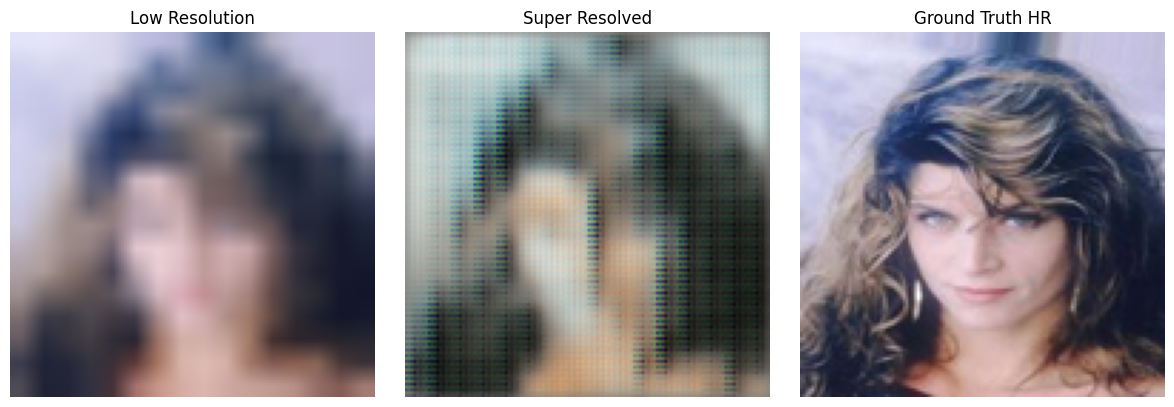

In [21]:
# Take one example from dataset
sample_lr_batch, sample_hr_batch = next(iter(dataset))
sample_lr = sample_lr_batch[0]
sample_hr = sample_hr_batch[0]

predict_and_show(generator, sample_lr, sample_hr)


In [2]:
%pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.3 MB/s eta 0:00:00
